In [25]:
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import statsmodels.tsa.stattools
import scipy.signal

In [90]:
T = 14000
n_steps_per_unit_time = 10
dt = 1/n_steps_per_unit_time
window_length = 700
n_windows = int(T/window_length) 

In [91]:
#show spurious EWS var, ac for increasing kappa and decreasing theta

#linear ramp for kappa
def kappa(t,k0,kT):
    return (1-t/T)*k0 + t/T*kT

#linear ramp for theta
def theta(t,th0,thT):
    return (1-t/T)*th0 + t/T*thT


def ls(t,l0):
    return l0*np.sqrt(1-t/T)


In [80]:
np.random.seed(4)
a = np.random.uniform(0.5,4,4)
k0,kT,th0,thT = np.random.uniform(0.5,4,4)
l0 = 1

In [92]:
k0, kT, th0, thT = 1, 3.5, 3, 1

In [70]:
a

array([2.42779266, 2.97851738, 1.51816659, 2.28789662])

In [93]:
#simulate sample paths with euler method
n_steps = T*n_steps_per_unit_time
solve_ts = np.linspace(0,T,n_steps + 1)


xs = np.zeros(n_steps+1)
us = np.zeros(n_steps+1)

#simulate us
for i in tqdm.trange(n_steps):
    us[i+1] = np.exp(-theta(solve_ts[i],th0,thT)*dt)*us[i] + np.sqrt(1/(2*theta(solve_ts[i],th0,thT))*(1-np.exp(-2*theta(solve_ts[i],th0,thT)*dt)))*np.random.normal(0,1)

for i in tqdm.trange(n_steps):
    xs[i+1] = xs[i] - ls(solve_ts[i],l0)*xs[i]*dt + kappa(solve_ts[i],k0,kT)*us[i]*dt

xs_filtered = xs[::n_steps_per_unit_time]

100%|██████████| 140000/140000 [00:00<00:00, 297477.41it/s]


In [24]:
#version with var and ar over several time units

def get_var(x):
    #get var of T-windows with length window length. Gives n_windows values
    var = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        var[i] = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2).var()
    return var


def get_ar(x):
#x should have size T*steps_per_unit_time + 1
    ar = np.full(n_windows,np.nan)
    for i in tqdm.trange(n_windows):
        ar[i] = statsmodels.tsa.stattools.acf(statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2))[1]
    return ar


In [99]:
#ls version without convolution, flexible parameter for kappa
#ToDo: k has to be flexible for increase, decrease. Here only for kappa decreasing

def get_ls_k(x,noise):


    def fitfunction(f,ls):
        return np.log(1/(f**2  + ls**2))
    

    n_windows = int(T/window_length) 
    ls = np.full(n_windows,np.nan)

    
    b = max(k0,kT)
    a = min(k0,kT)
    d = (b-a)/n_windows

    for i in tqdm.trange(n_windows):
        frequencies = 2*np.pi*(1/window_length)*np.arange(1,window_length/2)                                                #here window_length should be even

        xs_window_detrend = statsmodels.tsa.tsatools.detrend(x[i*window_length:(i+1)*window_length],order=2)
        noise_window = noise[i*window_length:(i+1)*window_length]

        k = b - d*(i+0.5)                                                                                                   #take the mean of kappa in the window
        
        estim_psd_xs_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[j]*np.arange(0,window_length)) @ xs_window_detrend))**2 for j in range(int(window_length/2) - 1)])
        estim_psd_xi_wn = np.array([np.abs(1/np.sqrt(window_length)*(np.exp(-1j*frequencies[n]*np.arange(0,window_length)) @ (noise_window*k)))**2 for n in range(int(window_length/2) - 1)])

        popt = scipy.optimize.curve_fit(fitfunction,
                                                  frequencies, 
                                                  np.log(estim_psd_xs_wn/estim_psd_xi_wn),
                                                  p0=[1.0],
                                                  bounds=(0.0, np.inf))[0]
        ls[i] = popt[0]

        
    return ls


In [100]:
var_xs = get_var(xs)
ar_xs = get_ar(xs)
ls_xs = get_ls_k(xs,us)

100%|██████████| 20/20 [00:00<00:00, 24.65it/s]


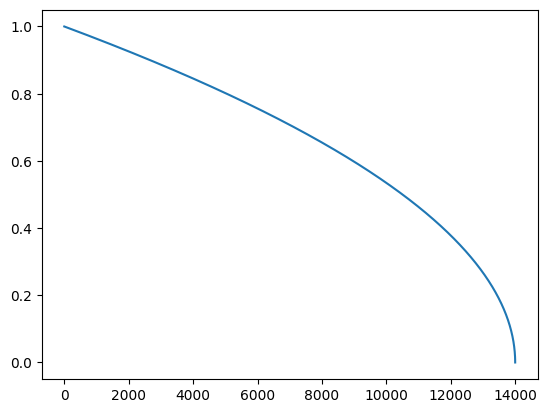

In [53]:
plt.plot(np.arange(T+1),ls(np.arange(T+1),l0))

Text(0.5, 0, 'mu')

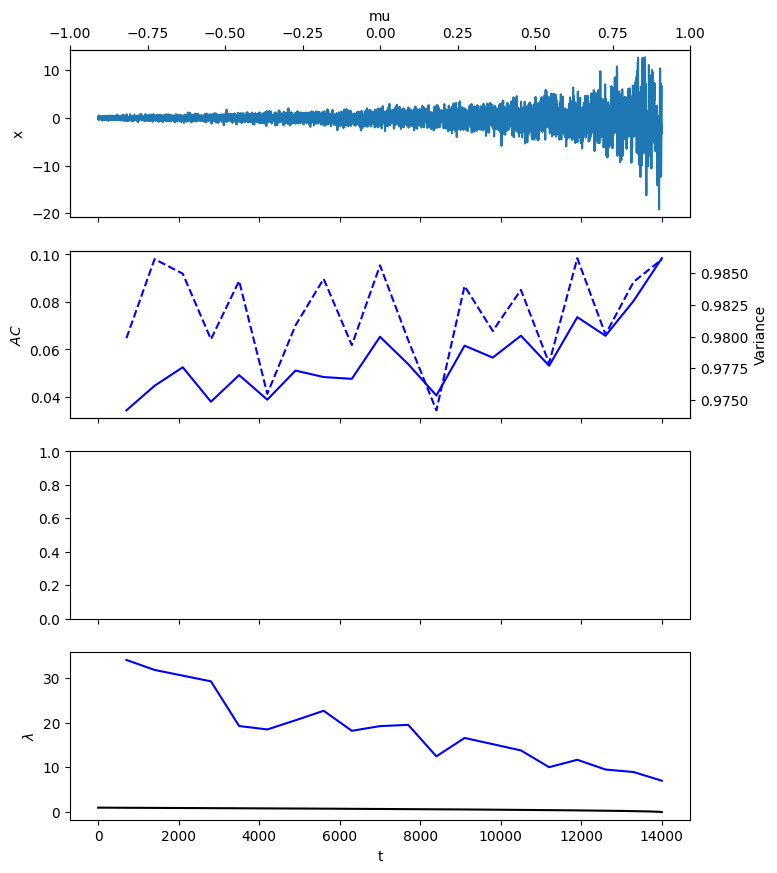

In [101]:
#why is lambda estimation so far from true lambda?, how to choose fs in ls method?  

ts = np.arange(T+1)

fig,axs = plt.subplots(nrows=4,ncols=1,sharex=True,figsize=(8,10)) 

axs[0].plot(ts,xs_filtered)


axs[1].plot(ts[window_length::window_length],var_xs,color="blue")                               
ax1_var = axs[1].twinx()
ax1_var.plot(ts[window_length::window_length],ar_xs,color="blue",linestyle="--")




axs[0].set_ylabel("x")
axs[1].set_ylabel(r"$AC$")
ax1_var.set_ylabel(r"Variance")



axs[3].set_xlabel("t")    
axs[3].plot(ts[window_length::window_length],ls_xs,color="blue")
axs[3].plot(ts,ls(ts,l0),color="black")
axs[3].set_ylabel(r"$\lambda$")


ax_0 = axs[0].twiny()
ax_0.set_xlim(-1,1)
ax_0.set_xlabel("mu")

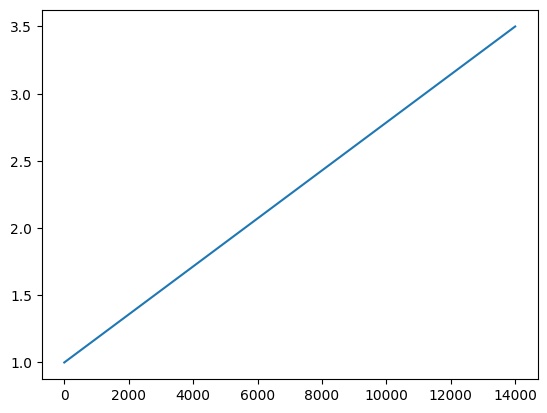

In [65]:
plt.plot(ts,kappa(ts,k0,kT))

In [60]:


x = np.zeros(1001)
x[0] = 5


for i in range(1000):
    x[i+1] = x[i] - x[i]*0.01

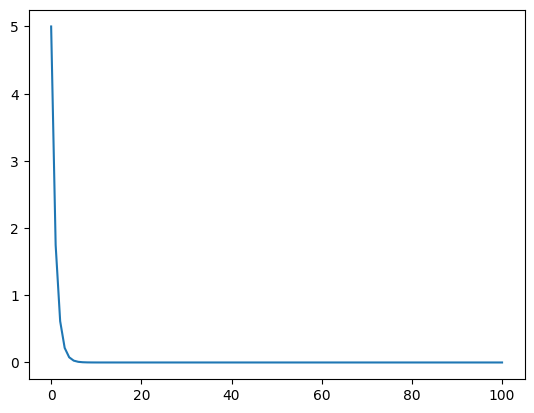

In [84]:
plt.plot(np.arange(T+1),xs_filtered)

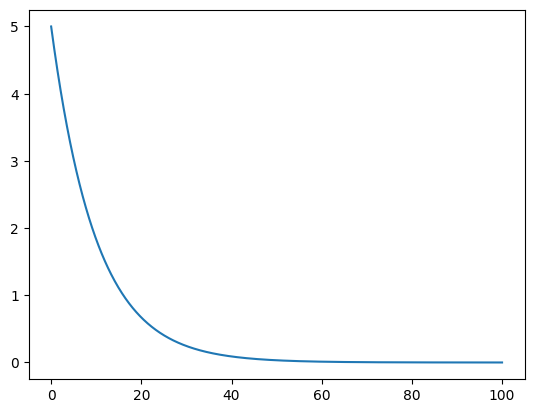

In [61]:
plt.plot(np.linspace(0,100,1001),x)